# 1 Read predictions CNN
        

Using TensorFlow backend.


Best CNN model found: 15843866222736194_inceptionv3_no_ceil


,macro_avg-precision,macro_avg-recall,macro_avg-f1-score,macro_avg-support,weighted_avg-precision,weighted_avg-recall,weighted_avg-f1-score,weighted_avg-support
accuracy,,,,,,,,
0.930661,0.925471,0.935916,0.929125,923,0.933543,0.930661,0.930544,923


Label train set shape: 7932, 12
Label valid set shape: 461, 12
Label test set shape: 923, 12

Image train set shape: 7932, 256, 256, 3
Image valid set shape: 461, 256, 256, 3
Image test set shape: 923, 256, 256, 3


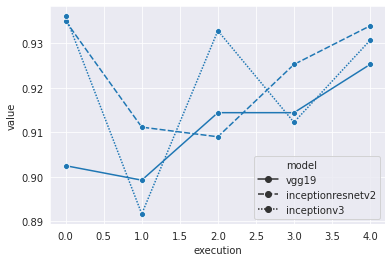

In [1]:
import os
import pandas as pd
import numpy as np
import re
import pickle
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, scale
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import warnings
from auxiliary_functions import *
from Utils import *
warnings.filterwarnings('ignore')

##############################################################
# Directories, files, parameters
##############################################################
plots_dir = "plots"
PATH = "results/"
feat_file='cloud_features.csv'

parameters_rf = {'n_estimators':list(range(100,1600,100))}
#parameters_rf = {'n_estimators':[200]}


##############################################################
# Obtaining best CNN execution (in validation set)
##############################################################

summary_files = [each for each in os.listdir(PATH) if each.endswith('_summary_acc.csv')]

# Generating dataframe with all summary files. New columns with file name, model name and set name (train,valid,test)
df = pd.concat((pd.read_csv(os.path.join(PATH, f)).assign(file = f).assign(model = re.search('[0-9]_+(.+?)_summary_acc.csv', f).group(1).split("_")[0]).
                assign(set = re.search('[0-9]_+(.+?)_summary_acc.csv', f.replace("no_ceil_", "")).group(1).split("_")[1]) for f in summary_files))

# Extracting validation results to find best execution
df_val = df[df["set"] == "valid"]
best_exec_acc_val = df_val[df_val["accuracy"] == max(df_val["accuracy"])]
file_best_exec = best_exec_acc_val["file"][0]
file_best_exec_id = re.search('(.+?)_[a-z]+_summary_acc.csv', file_best_exec).group(1)

#file_best_exec_id = "15843976137157693_vgg19_no_ceil"
#file_best_exec = "15843976137157693_vgg19_no_ceil_valid_summary_acc.csv"
##############################################################
# General statistics CNN
##############################################################


df['execution'] = df.groupby(['model', 'set']).cumcount()
df['execution'].astype('int32')
df_melt = pd.melt(df[df["set"] == "test"], id_vars=['model',  'execution'], value_vars=['accuracy'])

sns.set_style("darkgrid")
ax = sns.lineplot(x="execution", y="value", data=df_melt, estimator=None, style="model",  markers=["o", "o", "o"])



##############################################################
# Reading indices of the best CNN execution
##############################################################
# Reading indices of the best CNN execution
indices_file = file_best_exec.replace("valid_summary_acc.csv", "indices.pickle")
with open(os.path.join(PATH,indices_file), 'rb') as f:
    in_train, in_valid, in_test  = pickle.load(f)

##############################################################
# Reading predictions of the best CNN execution
##############################################################
# Reading predictions of the best CNN execution
preds_file = file_best_exec.replace("valid_summary_acc.csv", "preds.csv")
preds_cnn_train = pd.read_csv(os.path.join(PATH, "%s_train_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_test = pd.read_csv(os.path.join(PATH, "%s_test_preds.csv" % file_best_exec_id), index_col=0)
preds_cnn_valid = pd.read_csv(os.path.join(PATH, "%s_valid_preds.csv" % file_best_exec_id), index_col=0)


y_train = preds_cnn_train["obs"]
y_test = preds_cnn_test["obs"]
y_valid = preds_cnn_valid["obs"]


# Deleting observation column
del preds_cnn_train["obs"]
del preds_cnn_test["obs"]
del preds_cnn_valid["obs"]

test_summary_data_cnn = pd.read_csv(os.path.join(PATH, "%s_test_summary_acc.csv" % file_best_exec_id), index_col=0)
print("Best CNN model found: %s" % file_best_exec_id)
display(test_summary_data_cnn)

# Reading data and applying indices

data = load_data_with_indices("data/",
                in_train = in_train,
                in_valid = in_valid,
                in_test = in_test)

encoder = data["label_encoder"]
estimators_train = data['features'][0]
estimators_train.drop(["ceil.height0", "ceil.height1",
              "ceil.height2", "ceil.depth0",
              "ceil.depth1", "ceil.depth2",
              "ceil.layers"], axis=1)
estimators_test = data['features'][-1]
estimators_test.drop(["ceil.height0", "ceil.height1",
             "ceil.height2", "ceil.depth0",
             "ceil.depth1", "ceil.depth2",
             "ceil.layers"], axis=1)


img_train, ceil_train, y_train= data['train']
img_test, ceil_test, y_test= data['test']

y_train = data['label_encoder'].inverse_transform(data['train'][-1])

y_test = data['label_encoder'].inverse_transform(data['test'][-1])


preds_cnn_train_hot = encoder.transform(preds_cnn_train)
preds_cnn_valid_hot = encoder.transform(preds_cnn_valid)
preds_cnn_test_hot = encoder.transform(preds_cnn_test)


### Summary of features

- **preds_cnn_train, preds_cnn_test, preds_cnn_valid**: predictions of the best CNN model
- **estimators_train, estimators_test, estimators_valid**: estimators to train RF classifier
- **ceil_train, ceil_test, ceil_valid**: features to combine with outputs of RF and CNN classifiers



## Experiment 2: RF on estimators classification

,Classifier,Train_accuracy,Test_accuracy
0,LogisticRegression,0.8346,0.7291
1,LinearDiscriminantAnalysis,0.7776,0.7021
2,KNeighborsClassifier,0.9420,0.7389
3,DecisionTreeClassifier,1.0000,0.8158
4,GaussianNB,0.5609,0.4789
5,SVM-linear,0.9255,0.8093
6,SVM-poly,0.8187,0.6793
7,SVM-rbf,0.8821,0.7703
8,SVM-sigmoid,0.4320,0.3965
9,RandomForestClassifier,1.0000,0.8960


Grid search Random Forest
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:  9.8min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 11.2min finished


RF on training set results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.462295,0.118618,0.034218,0.000851,100,{'n_estimators': 100},0.967864,0.974795,0.975410,0.972257,0.983607,0.974787,0.005148,15
1,17.043066,0.271697,0.065840,0.002594,200,{'n_estimators': 200},0.970384,0.977316,0.976040,0.974149,0.984237,0.976425,0.004553,1
2,25.365253,0.442992,0.096214,0.002182,300,{'n_estimators': 300},0.969124,0.974795,0.977932,0.974149,0.984868,0.976174,0.005184,2
3,34.008645,0.474922,0.129371,0.005727,400,{'n_estimators': 400},0.969124,0.976055,0.976671,0.972888,0.984868,0.975921,0.005216,4
4,42.735108,1.214916,0.159271,0.002995,500,{'n_estimators': 500},0.970384,0.974165,0.977301,0.972888,0.984868,0.975921,0.004998,3
5,51.045366,0.977259,0.194264,0.004362,600,{'n_estimators': 600},0.969124,0.974165,0.976671,0.972888,0.984868,0.975543,0.005261,5
6,59.219841,0.756403,0.222127,0.004802,700,{'n_estimators': 700},0.968494,0.972275,0.977301,0.973518,0.984868,0.975291,0.005553,7
7,68.208339,0.745762,0.253469,0.005211,800,{'n_estimators': 800},0.967864,0.973535,0.976671,0.972888,0.984868,0.975165,0.005613,11
8,76.248235,1.321581,0.286180,0.005792,900,{'n_estimators': 900},0.968494,0.973535,0.976671,0.972888,0.984868,0.975291,0.005453,8
9,84.553858,1.231848,0.316600,0.005189,1000,{'n_estimators': 1000},0.968494,0.973535,0.976671,0.973518,0.984237,0.975291,0.005184,10


                precision    recall  f1-score   support

       aerosol     0.9524    1.0000    0.9756        20
   altocumulos     0.8523    0.8523    0.8523        88
   altostratos     0.9412    0.8889    0.9143        36
cieloDespejado     1.0000    0.8261    0.9048        23
  cirrocumulos     0.6364    0.6667    0.6512        21
        cirros     0.9103    0.9793    0.9435       145
  cirrostratos     0.9688    0.9118    0.9394        68
       cumulos     0.9429    0.9296    0.9362        71
estratocumulos     0.8912    0.9225    0.9066       142
      estratos     0.9204    0.9630    0.9412       108
     multinube     0.9000    0.8571    0.8780       189
  nimbostratos     0.5556    0.4167    0.4762        12

      accuracy                         0.9014       923
     macro avg     0.8726    0.8512    0.8599       923
  weighted avg     0.9012    0.9014    0.9004       923



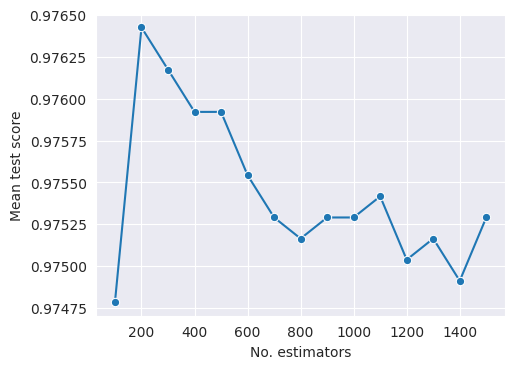

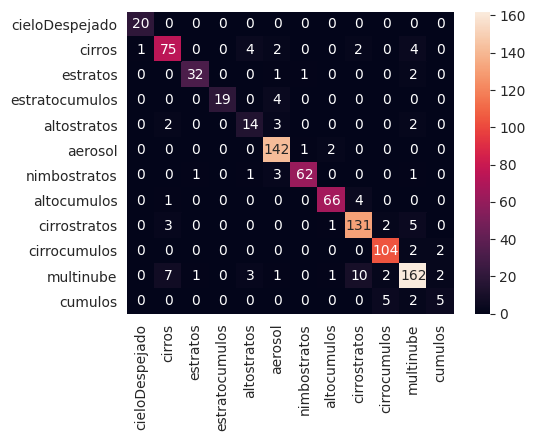

In [2]:

##############################################################
# Experiment 2: RF on estimators classification
##############################################################
experiment_name = "EXP_2_RF_estimators"

##############################################################
# Classic classifiers comparison
##############################################################
train_classifiers_on_set(X_train=estimators_train, Y_train=y_train, 
                         X_test=estimators_test, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, 
                         output_dir=plots_dir, encoder=encoder)

##############################################################
# Training RF with different no. estimators
##############################################################
preds_estimators_test_RF_hot, preds_estimators_train_RF_hot = grid_search_rf(
    X_train=estimators_train, Y_train=y_train, X_test=estimators_test, Y_test=y_test,
               encoder=encoder, parameters_rf=parameters_rf, file_best_exec_id=file_best_exec_id,
               experiment_name=experiment_name, output_dir=plots_dir)



## Experiment 3: Average of RF over estimators + CNN predictions

                precision    recall  f1-score   support

       aerosol      1.000     1.000     1.000        20
   altocumulos      0.848     0.955     0.898        88
   altostratos      0.846     0.917     0.880        36
cieloDespejado      1.000     0.957     0.978        23
  cirrocumulos      0.947     0.857     0.900        21
        cirros      0.935     0.986     0.960       145
  cirrostratos      0.970     0.941     0.955        68
       cumulos      0.921     0.986     0.952        71
estratocumulos      0.918     0.944     0.931       142
      estratos      0.971     0.926     0.948       108
     multinube      0.964     0.847     0.901       189
  nimbostratos      0.786     0.917     0.846        12

      accuracy                          0.931       923
     macro avg      0.925     0.936     0.929       923
  weighted avg      0.934     0.931     0.931       923



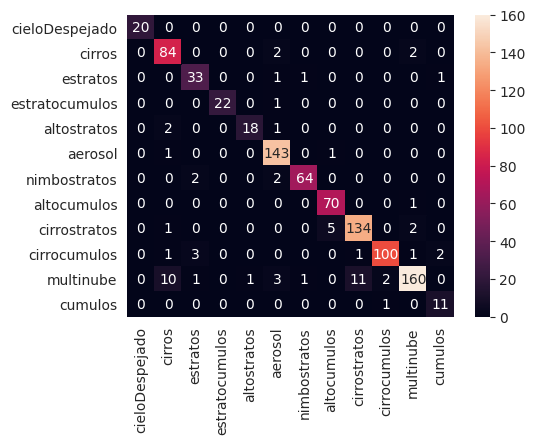

In [3]:
##############################################################
# Experiment 3: Average of RF over estimators + CNN predictions
##############################################################
experiment_name = "EXP_3_RF_estimators_CNN"

# Test set of classifiers
#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
preds_estimators_test_RF_CNN = encoder.inverse_transform((preds_estimators_test_RF_hot + preds_cnn_test_hot)/2)

print(classification_report(y_pred= preds_estimators_test_RF_CNN, y_true= y_test, digits= 3))
generate_confusion_matrix_and_report(y_pred=preds_estimators_test_RF_CNN, y_test_dec=y_test, output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir)


## Experiment 4: Standard classifiers on CNN predictions + RF over estimators

In [6]:
##############################################################
# Experiment 4: Standard classifiers on CNN predictions + RF over estimators
##############################################################
experiment_name = "EXP_4_standard_classifiers_CNN_RF"
print("EXPERIMENT %s" % experiment_name)


#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
#preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

x_train_cnn_rf_predictions = np.concatenate((preds_estimators_train_RF_hot, preds_cnn_train_hot), axis=1)
x_test_cnn_rf_predictions = np.concatenate((preds_estimators_test_RF_hot, preds_cnn_test_hot), axis=1)



train_classifiers_on_set(X_train=x_train_cnn_rf_predictions, Y_train=y_train, 
                         X_test=x_test_cnn_rf_predictions, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, output_dir=plots_dir,
                         encoder=encoder)



EXPERIMENT EXP_4_standard_classifiers_CNN_RF


,Classifier,Train_accuracy,Test_accuracy
0,LogisticRegression,1.0000,0.9502
1,LinearDiscriminantAnalysis,1.0000,0.9133
2,KNeighborsClassifier,0.9985,0.9534
3,DecisionTreeClassifier,1.0000,0.8797
4,GaussianNB,0.9989,0.8711
5,SVM-linear,1.0000,0.9469
6,SVM-poly,1.0000,0.9177
7,SVM-rbf,1.0000,0.9328
8,SVM-sigmoid,0.9997,0.9372
9,RandomForestClassifier,1.0000,0.9166


## Experiment 5: Standard classifiers on CNN predictions + RF over estimators + CEIL features

In [7]:
experiment_name = "EXP_5_standard_classifiers_ceil_CNN_RF"

#preds_estimators_test_RF_hot = grid_rf.predict(estimators_test)
#preds_estimators_test_RF = encoder.inverse_transform(preds_estimators_test_RF_hot)

x_train_ceil_cnn_rf_predictions = np.concatenate((preds_estimators_train_RF_hot, preds_cnn_train_hot, ceil_train), axis=1)
x_test_ceil_cnn_rf_predictions = np.concatenate((preds_estimators_test_RF_hot, preds_cnn_test_hot, ceil_test), axis=1)



train_classifiers_on_set(X_train=x_train_ceil_cnn_rf_predictions, Y_train=y_train, 
                         X_test=x_test_ceil_cnn_rf_predictions, Y_test=y_test, 
                         output_file_id=file_best_exec_id, experiment_name=experiment_name, 
                         output_dir=plots_dir, encoder=encoder)

,Classifier,Train_accuracy,Test_accuracy
0,LogisticRegression,1.0000,0.9512
1,LinearDiscriminantAnalysis,1.0000,0.9133
2,KNeighborsClassifier,0.9957,0.9447
3,DecisionTreeClassifier,1.0000,0.8819
4,GaussianNB,0.9989,0.8700
5,SVM-linear,1.0000,0.9415
6,SVM-poly,0.9975,0.9393
7,SVM-rbf,0.9997,0.9502
8,SVM-sigmoid,0.9878,0.9339
9,RandomForestClassifier,1.0000,0.9177
